In [3]:
import pandas as pd
import datetime as dt
import numpy as np

In [4]:
df = pd.read_csv("/home/musa/Desktop/ArNext-Intelligence/NoteBook/Results.csv")
df.head()

,customer_id,delivery_date,delivery_invoice_amount,customer_name
0,68098,2023-12-19,921972.133390,M/S Alam Trading Corporation (Wheat)
1,111401,2025-10-25,256870.000000,TECHNICAL SOLUTION
2,68098,2023-12-19,983922.830100,M/S Alam Trading Corporation (Wheat)
3,111685,2026-01-04,101072.000000,M/S Maa Enterprise-Kawranbazar (Dist)
4,68098,2023-12-18,678360.128975,M/S Alam Trading Corporation (Wheat)


In [5]:
# Ensure PurchaseDate is datetime
df['delivery_date'] = pd.to_datetime(df['delivery_date'])

In [6]:
df_recency = (
    df.groupby('customer_id', as_index=False)
      .agg(
          customer_name=('customer_name', 'first'),
          LastPurchaseDate=('delivery_date', 'max')
      )
)

# Reference date (most recent purchase in dataset)
recent_date = df_recency['LastPurchaseDate'].max()

# Calculate recency in days
df_recency['Recency'] = (recent_date - df_recency['LastPurchaseDate']).dt.days

df_recency.head()


,customer_id,customer_name,LastPurchaseDate,Recency
0,442,Bengal Cement Ltd,2025-01-27,358
1,443,Aramit Cement Limited,2022-04-28,1363
2,444,Bahadurpur Tea Estate Ltd.,2024-07-03,566
3,445,Akij Essentials Ltd,2025-12-31,20
4,446,Bashundhara Industries Complex Ltd.,2024-05-23,607


## Calculate Frequency

In [7]:
frequency_df = (
    df.drop_duplicates()
      .groupby('customer_id', as_index=False)
      .agg(
          customer_name=('customer_name', 'first'),
          Frequency=('delivery_date', 'count')
      )
)

frequency_df.head()


,customer_id,customer_name,Frequency
0,442,Bengal Cement Ltd,109
1,443,Aramit Cement Limited,8
2,444,Bahadurpur Tea Estate Ltd.,5
3,445,Akij Essentials Ltd,351
4,446,Bashundhara Industries Complex Ltd.,6


# Calulate Monetary

In [9]:
df['Total'] = df['delivery_invoice_amount'].fillna(0).clip(lower=0)

monetary_df = (
    df.groupby('customer_id', as_index=False)
      .agg(
          customer_name=('customer_name', 'first'),
          Monetary=('Total', 'sum')
      )
)

monetary_df.head()


,customer_id,customer_name,Monetary
0,442,Bengal Cement Ltd,1.283467e+08
1,443,Aramit Cement Limited,1.495000e+07
2,444,Bahadurpur Tea Estate Ltd.,7.767470e+05
3,445,Akij Essentials Ltd,5.597042e+08
4,446,Bashundhara Industries Complex Ltd.,5.657540e+06


In [10]:
rfm_df = (
    df_recency
    .merge(monetary_df, on=['customer_id', 'customer_name'], how='inner')
    .merge(frequency_df, on=['customer_id', 'customer_name'], how='inner')
    .drop(columns='LastPurchaseDate')
)

rfm_df.head()


,customer_id,customer_name,Recency,Monetary,Frequency
0,442,Bengal Cement Ltd,358,1.283467e+08,109
1,443,Aramit Cement Limited,1363,1.495000e+07,8
2,444,Bahadurpur Tea Estate Ltd.,566,7.767470e+05,5
3,445,Akij Essentials Ltd,20,5.597042e+08,351
4,446,Bashundhara Industries Complex Ltd.,607,5.657540e+06,6


In [11]:
rfm_df["R_rank"] = rfm_df['Recency'].rank(ascending=True)
rfm_df["F_rank"] = rfm_df['Frequency'].rank(ascending=True)
rfm_df["M_rank"] = rfm_df['Monetary'].rank(ascending=True)


In [12]:
rfm_df["R_rank_norm"] = (rfm_df['R_rank']) / rfm_df['R_rank'].max() * 100
rfm_df["F_rank_norm"] = (rfm_df['F_rank']) / rfm_df['F_rank'].max() * 100
rfm_df["M_rank_norm"] = (rfm_df['M_rank']) / rfm_df['M_rank'].max() * 100    
rfm_df.head()

,customer_id,customer_name,Recency,Monetary,Frequency,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm
0,442,Bengal Cement Ltd,358,1.283467e+08,109,5850.0,22645.0,23114.0,24.688753,95.568685,97.548006
1,443,Aramit Cement Limited,1363,1.495000e+07,8,21039.0,17953.0,20434.0,88.790884,75.767039,86.237603
2,444,Bahadurpur Tea Estate Ltd.,566,7.767470e+05,5,11668.5,16797.0,14360.0,49.244566,70.888373,60.603503
3,445,Akij Essentials Ltd,20,5.597042e+08,351,1403.0,23284.0,23598.0,5.921080,98.265457,99.590631
4,446,Bashundhara Industries Complex Ltd.,607,5.657540e+06,6,11820.5,17258.0,18501.0,49.886052,72.833931,78.079764


In [13]:
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
rfm_df.head()

,customer_id,customer_name,Recency,Monetary,Frequency,R_rank_norm,F_rank_norm,M_rank_norm
0,442,Bengal Cement Ltd,358,1.283467e+08,109,24.688753,95.568685,97.548006
1,443,Aramit Cement Limited,1363,1.495000e+07,8,88.790884,75.767039,86.237603
2,444,Bahadurpur Tea Estate Ltd.,566,7.767470e+05,5,49.244566,70.888373,60.603503
3,445,Akij Essentials Ltd,20,5.597042e+08,351,5.921080,98.265457,99.590631
4,446,Bashundhara Industries Complex Ltd.,607,5.657540e+06,6,49.886052,72.833931,78.079764


In [14]:
rfm_df['RFM_Score'] = 0.25 * rfm_df['R_rank_norm'] + 0.30 * rfm_df['F_rank_norm'] + 0.45 * rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df.head()

,customer_id,customer_name,Recency,Monetary,Frequency,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0,442,Bengal Cement Ltd,358,1.283467e+08,109,24.69,95.57,97.55,3.94
1,443,Aramit Cement Limited,1363,1.495000e+07,8,88.79,75.77,86.24,4.19
2,444,Bahadurpur Tea Estate Ltd.,566,7.767470e+05,5,49.24,70.89,60.60,3.04
3,445,Akij Essentials Ltd,20,5.597042e+08,351,5.92,98.27,99.59,3.79
4,446,Bashundhara Industries Complex Ltd.,607,5.657540e+06,6,49.89,72.83,78.08,3.47


In [15]:
rfm_df[["customer_id",'RFM_Score','customer_name']].head(7)

,customer_id,RFM_Score,customer_name
0,442,3.94,Bengal Cement Ltd
1,443,4.19,Aramit Cement Limited
2,444,3.04,Bahadurpur Tea Estate Ltd.
3,445,3.79,Akij Essentials Ltd
4,446,3.47,Bashundhara Industries Complex Ltd.
5,456,1.99,AMAN CEMENT MILLS UNIT-II LTD.
6,462,3.90,ACI Godrej Agrovet Ltd.


In [21]:
rfm_df["Customer_segment"] = np.where(
    rfm_df['RFM_Score'] > 4.5, "Platinum",
    np.where(
        rfm_df['RFM_Score'] > 4.0, "Gold",
        np.where(
            rfm_df['RFM_Score'] > 3.0, "Silver",
            np.where(
                rfm_df['RFM_Score'] > 1.6, "Occasional",
                "Inactive Customers"
            )
        )
    )
)


In [22]:
rfm_df[['customer_id', 'RFM_Score', 'Customer_segment','customer_name']].head(20)

,customer_id,RFM_Score,Customer_segment,customer_name
0,442,3.94,Silver,Bengal Cement Ltd
1,443,4.19,Gold,Aramit Cement Limited
2,444,3.04,Silver,Bahadurpur Tea Estate Ltd.
3,445,3.79,Silver,Akij Essentials Ltd
4,446,3.47,Silver,Bashundhara Industries Complex Ltd.
5,456,1.99,Occasional,AMAN CEMENT MILLS UNIT-II LTD.
6,462,3.90,Silver,ACI Godrej Agrovet Ltd.
7,470,3.75,Silver,Heidelberg Materials Bangladesh PLC
8,472,3.94,Silver,Mir Cement Ltd.
9,480,3.86,Silver,Nourish Agro Ltd.


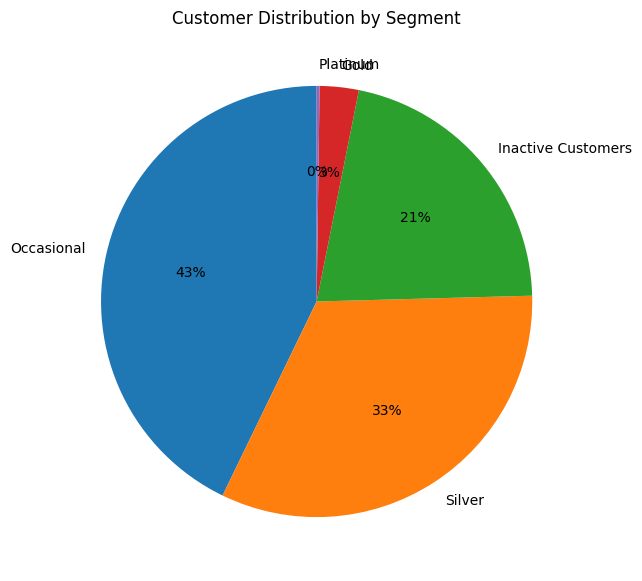

In [23]:
segment_counts = rfm_df['Customer_segment'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(
    segment_counts,
    labels=segment_counts.index,
    autopct='%1.0f%%',
    startangle=90
)
plt.title('Customer Distribution by Segment')
plt.show()



# Customer Segment

In [24]:
segment_summary = (
    rfm_df
    .groupby('Customer_segment')
    .agg(
        Total_Customers=('customer_id', 'nunique'),
        Total_Frequency=('Frequency', 'sum'),
        Total_Spend=('Monetary', 'sum')
    )
    .reset_index()
)

segment_summary


,Customer_segment,Total_Customers,Total_Frequency,Total_Spend
0,Gold,693,105976,4.758422e+10
1,Inactive Customers,5077,5398,5.245938e+08
2,Occasional,10145,22701,7.997872e+09
3,Platinum,52,12166,7.161085e+09
4,Silver,7728,623092,3.979792e+11


# Platinum Customers


In [27]:
platinum_df = rfm_df[rfm_df['Customer_segment'] == 'Platinum']
platinum_df = platinum_df.drop(['R_rank_norm', 'F_rank_norm','M_rank_norm'], axis=1)
platinum_df.head()

,customer_id,customer_name,Recency,Monetary,Frequency,RFM_Score,Customer_segment
40,567,Sara Enterprise (Wastage),1342,2.205081e+07,70,4.51,Platinum
69,12106,Akij Glass Industries Ltd,1092,2.159003e+08,1037,4.66,Platinum
72,12125,Akij Cement Ready-Mix Concrete,1319,1.692118e+08,176,4.77,Platinum
76,12129,Akij Cement Ready-Mix Concrete Plant-01,1320,3.005690e+08,1265,4.82,Platinum
81,14008,USAFE TRADING PTE LTD,1208,7.854397e+07,42,4.61,Platinum


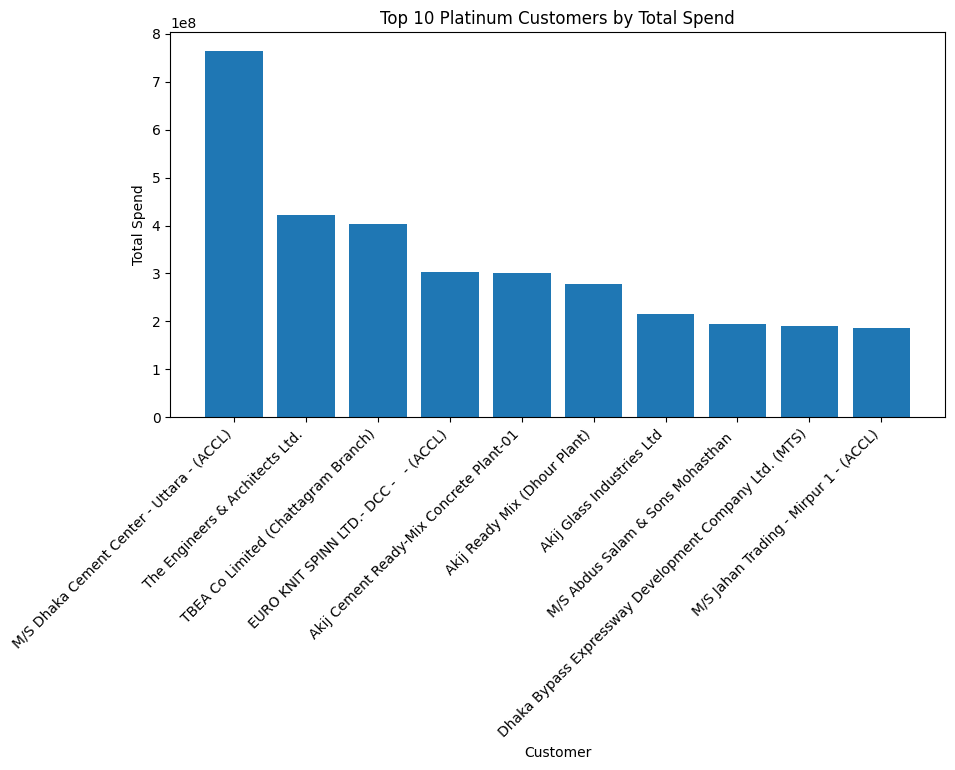

In [29]:
## Top Platinum Customers by Spend
top_platinum = (
    platinum_df
    .sort_values('Monetary', ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 5))
plt.bar(top_platinum['customer_name'], top_platinum['Monetary'])
plt.title('Top 10 Platinum Customers by Total Spend')
plt.xlabel('Customer')
plt.ylabel('Total Spend')
plt.xticks(rotation=45, ha='right')
plt.show()


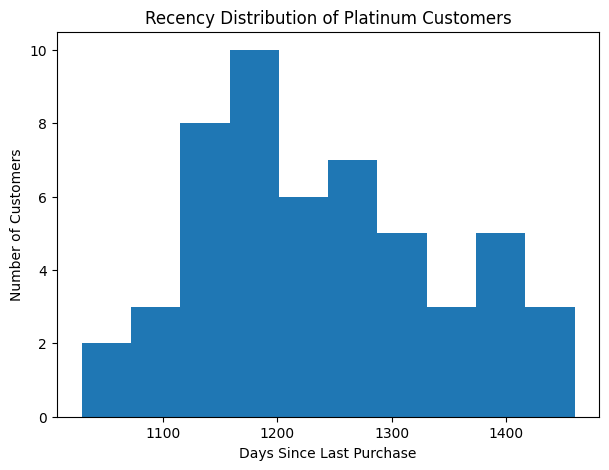

In [31]:
# Recency Distribution (Risk monitoring)
plt.figure(figsize=(7, 5))
plt.hist(platinum_df['Recency'], bins=10)
plt.title('Recency Distribution of Platinum Customers')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Number of Customers')
plt.show()


# Gold Customers

In [34]:
gold_df = rfm_df[rfm_df['Customer_segment'] == 'Gold']
gold_df = gold_df.drop(['R_rank_norm', 'F_rank_norm','M_rank_norm'], axis=1)
gold_df.head()

,customer_id,customer_name,Recency,Monetary,Frequency,RFM_Score,Customer_segment
1,443,Aramit Cement Limited,1363,1.495000e+07,8,4.19,Gold
10,490,Aftab Feed Products Ltd.,912,3.579775e+07,17,4.07,Gold
12,502,RRP Agro Farms,1481,2.496975e+07,7,4.33,Gold
18,517,Akij Textile Mills Ltd.,940,6.546264e+07,52,4.29,Gold
21,524,Unique Trade Corporation,422,2.292849e+08,276,4.02,Gold


# Silver Customers

In [35]:
silver_df = rfm_df[rfm_df['Customer_segment'] == 'Silver']
silver_df = silver_df.drop(['R_rank_norm', 'F_rank_norm','M_rank_norm'], axis=1)
silver_df.head()

,customer_id,customer_name,Recency,Monetary,Frequency,RFM_Score,Customer_segment
0,442,Bengal Cement Ltd,358,1.283467e+08,109,3.94,Silver
2,444,Bahadurpur Tea Estate Ltd.,566,7.767470e+05,5,3.04,Silver
3,445,Akij Essentials Ltd,20,5.597042e+08,351,3.79,Silver
4,446,Bashundhara Industries Complex Ltd.,607,5.657540e+06,6,3.47,Silver
6,462,ACI Godrej Agrovet Ltd.,432,1.701416e+08,41,3.90,Silver


# Occasional Customers

In [36]:
occasional_df = rfm_df[rfm_df['Customer_segment'] == 'Occasional']
occasional_df = occasional_df.drop(['R_rank_norm', 'F_rank_norm','M_rank_norm'], axis=1)
occasional_df.head()

,customer_id,customer_name,Recency,Monetary,Frequency,RFM_Score,Customer_segment
5,456,AMAN CEMENT MILLS UNIT-II LTD.,250,833175.0,1,1.99,Occasional
20,522,Akij Printing & Packages Ltd. (Customer),1146,272520.0,5,2.95,Occasional
27,531,Sonarupa Tea Estate Ltd,210,1996814.0,10,2.98,Occasional
33,551,Akij Match Factory Ltd. (Wastage),1083,38750.0,2,1.78,Occasional
37,557,Akij Printing & Packages Ltd. (Wastage),1507,63352.0,2,2.14,Occasional


# Inactive Customers

In [38]:
inactive_df = rfm_df[rfm_df['Customer_segment'] == 'Inactive Customers']
inactive_df = inactive_df.drop(['R_rank_norm', 'F_rank_norm','M_rank_norm'], axis=1)
inactive_df.head()

,customer_id,customer_name,Recency,Monetary,Frequency,RFM_Score,Customer_segment
51,12020,Land And Properties Ltd,1401,48500.0,1,1.55,Inactive Customers
70,12109,MS Akash Enterprise,1546,32200.0,1,1.59,Inactive Customers
555,15123,PACKMAT INDUSTRIAL Ltd (UNIT-2),1343,50500.0,1,1.54,Inactive Customers
608,15256,SK AKIJ UDDIN Ltd,749,4910.0,1,1.06,Inactive Customers
618,15295,TASLIM CHOWDHURY,863,50500.0,1,1.18,Inactive Customers
